In [1]:
import json
import numpy as np
from tqdm import tqdm
import glob as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore, mannwhitneyu, ttest_ind, ks_2samp, wilcoxon, ranksums
import pybedtools as pbt
from IPython.display import clear_output
from ipyparallel import Client
import seaborn.apionly as sns
from statsmodels.sandbox.stats.multicomp import multipletests

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

# DVIEW = Client()[:]
# DVIEW.block=True
# len(DVIEW)

In [2]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

gencode_data = json.load(open('../data/annotation/hg19_gencode.json'))
gene_strand = {}
for i in gencode_data:
    g = gencode_data[i]['gene_name']
    s = gencode_data[i]['strand'] 
    if gencode_data[i]['chrom'] in chroms:
        if g in gene_strand:
            if gene_strand[g] != s:
                pass
        else:
            gene_strand[g] = s
len(gene_strand)

58171

In [3]:
chrom_wise_gene_locus_map = {x:{} for x in chroms}
phendc3_up_genes = []
phendc3_down_genes = []
with open('../data/ligands_rna_seq/GSE60630_phendc3_ht1080') as h:
    next(h)
    for l in h:
        c = l.rstrip('\n').split('\t')
        chrom = c[3].split(':')[0]
        if chrom in chrom_wise_gene_locus_map and c[2] in gene_strand:
            chrom_wise_gene_locus_map[chrom][c[2]] = [
                int(x) for x in c[3].split(':')[1].split('-')] + [gene_strand[c[2]]]
            if float(c[12]) < 0.05:
                if float(c[9]) > np.log2(1.5):
                    phendc3_up_genes.append(c[2])
                elif float(c[9]) < np.log2(0.5):
                    phendc3_down_genes.append(c[2])
len(chrom_wise_gene_locus_map), len(phendc3_up_genes), len(phendc3_down_genes)

(24, 1594, 718)

(5, 0)


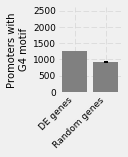

[1270, 915.97000000000003] 1.38650829176 (5, 0) MannwhitneyuResult(statistic=205.0, pvalue=0.044442768831605584)
(15, 0)


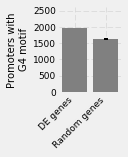

[1977, 1626.1199999999999] 1.2157774334 (15, 0) MannwhitneyuResult(statistic=229.0, pvalue=0.11385430944653702)
(25, 0)


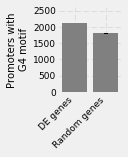

[2129, 1803.45] 1.18051512379 (25, 0) MannwhitneyuResult(statistic=237.0, pvalue=0.14885025128924356)
(5, 5)


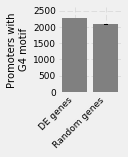

[2265, 2074.75] 1.09169779492 (5, 5) MannwhitneyuResult(statistic=255.0, pvalue=0.2513730934210644)
(15, 5)


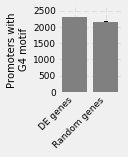

[2307, 2156.8400000000001] 1.06962037054 (15, 5) MannwhitneyuResult(statistic=262.0, pvalue=0.29950327567429136)
(25, 5)


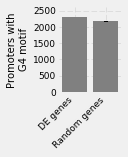

[2312, 2168.8699999999999] 1.06599289031 (25, 5) MannwhitneyuResult(statistic=262.5, pvalue=0.30309509554488639)


In [6]:
def calc_overlap(chrom):
    import pybedtools as pbt
    import numpy as np

    def load_g4_bed():
        g4_bed = []
        with open('/home/parashar/scratch/quadruplexes/hg19/g3_%s_%s_%s_nov.bed' %
                  (loop, bulge, chrom)) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                s = '+' if c[4] == 'G' else '-'
                g4_bed.append('\t'.join(map(str, [c[0], c[1], c[2], '.', '0', s])))
        g4_bed = pbt.BedTool('\n'.join(g4_bed), from_string=True)
        return g4_bed

    def load_de_non_de_genes():
        de_bed = []
        rest_bed = []
        for gene, info in gene_info[chrom].items():
            if info[2] == '+':
                bed_line = '\t'.join(map(str, [chrom, info[0]-offset, info[0]+offset,
                                               gene, '0', info[2]]))
            else:
                bed_line = '\t'.join(map(str, [chrom, info[1]-offset, info[1]+offset,
                                               gene, '0', info[2]]))
            if gene in de_genes:
                de_bed.append(bed_line)
            else:
                rest_bed.append(bed_line)

        de_bed = pbt.BedTool('\n'.join(de_bed), from_string=True)
        rest_bed = pbt.BedTool('\n'.join(rest_bed), from_string=True)
        return de_bed, rest_bed

    g4_bed = load_g4_bed()
    de_bed, rest_bed = load_de_non_de_genes()
    g4_de = de_bed.intersect(g4_bed, u=True).count()
    
    rest_genes = []
    for i in rest_bed:
        rest_genes.append(str(i.name))
    rest_genes = np.array(list(set(rest_genes)))
    g4_rest = rest_bed.intersect(g4_bed, wo=True)
    g4_rest_genes = []
    for i in g4_rest:
        g4_rest_genes.append(str(i.name))
    g4_rest_genes = np.array(list(set(g4_rest_genes)))
    
    g4_rests = []
    for i in range(100):
        random_genes = set([rest_genes[np.random.randint(len(rest_genes))]
                        for x in range(len(de_bed))])
        g4_rests.append(len(random_genes.intersection(g4_rest_genes)))
    
    return g4_de, g4_rests

offset = 500
configs = [(5, 0), (15, 0), (25, 0), (5, 5), (15, 5), (25, 5)]

for config in configs:
    loop = str(config[0])
    bulge = str(config[1])

    _ = DVIEW.push(dict(
        de_genes=phendc3_up_genes+phendc3_down_genes,
        gene_info=chrom_wise_gene_locus_map,
        loop=loop,
        bulge=bulge,
        offset=offset
    ))
    
    print (config)
    
    res = DVIEW.map_sync(calc_overlap, chroms)
    g4_de, g4_rests = [], []
    for i in res:
        g4_de.append(i[0])
        g4_rests.append(i[1])
    g4_de = np.array(g4_de)
    g4_rests = np.array(g4_rests)
    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))
    x = [1,2]
    y = [g4_de.sum(), g4_rests.sum(axis=0).mean()]
    ax.bar(x, y, yerr=[0, g4_rests.sum(axis=0).std()], color='grey')
    ax.set_ylabel('Promoters with\nG4 motif', fontsize=10)
    ax.set_xticklabels(['', 'DE genes', 'Random genes'], fontsize=9, rotation=45, ha='right')
    ax.set_ylim((0, 2600))
    ax.set_yticks([x for x in range(0, 2600, 500)])
    clean_axis(ax)
    plt.tight_layout()
    plt.savefig('../images/phendc3_rna_seq_G4_%d_%d.png' % (config[0], config[1]), dpi=300,
                transparent=True, edgecolor='none')
    plt.savefig('../images/phendc3_rna_seq_G4_%d_%d.svg' % (config[0], config[1]),
                transparent=True, edgecolor='none')
    plt.show()
    print (y, y[0]/y[1], config, mannwhitneyu(g4_de, g4_rests.mean(axis=1)))

In [4]:
def load_scores(chrom, chrom_info, strand):
    fn = '../data/snipr/%s_%s_scores.npy' % (chrom, strand)
    return np.load(fn, mmap_mode='r')

gene_names = []
snipr_scores = []
offset = 500
for chrom in chroms:
    print (chrom)
    temp = []
    pos_exp = load_scores(chrom, chrom_info, 'positive')
    neg_exp = load_scores(chrom, chrom_info, 'negative')
    for gene, info in chrom_wise_gene_locus_map[chrom].items():
        gene_names.append(gene)
        if info[2] == '+':
            pos_score = pos_exp[info[0] - offset : info[0] + offset]
            neg_score = neg_exp[info[0] - offset : info[0] + offset]
        else:
            pos_score = pos_exp[info[1] - offset : info[1] + offset][::-1]
            neg_score = neg_exp[info[1] - offset : info[1] + offset][::-1]
        temp.append(np.array(pos_score) + np.array(neg_score))
    snipr_scores.append(np.array(temp))
    clear_output()

In [5]:
de_snipr = []
rest_snipr = []
for n,chrom in enumerate(chroms):
    de_temp = []
    rest_temp = []
    for i,gene in enumerate(chrom_wise_gene_locus_map[chrom]):
        if gene in phendc3_up_genes or gene in phendc3_down_genes:
            de_temp.append(snipr_scores[n][i])
        else:
            rest_temp.append(snipr_scores[n][i])
    de_snipr.extend(de_temp)
    rest_snipr.extend(rest_temp)
de_snipr = np.array(de_snipr)
rest_snipr = np.array(rest_snipr)
de_snipr.shape, rest_snipr.shape

((2312, 1000), (18738, 1000))

In [6]:
pvals = []
de = de_snipr.mean(axis=1)
nonde_snipr = []
for i in tqdm(range(1000)):
    b = np.array([rest_snipr[np.random.randint(len(rest_snipr))]
                  for x in range(len(de))])
    nonde_snipr.extend(b)
    x = [de[np.random.randint(len(de))] for x in range(100)]
    y = np.array([b[np.random.randint(len(b))] for x in range(100)])
    pvals.append(mannwhitneyu(x, y.mean(axis=1))[1])
nonde_snipr = np.array(nonde_snipr)
nonde = nonde_snipr.mean(axis=1)
nonde_snipr.shape

100%|██████████| 1000/1000 [00:29<00:00, 34.27it/s]


(2312000, 1000)

In [7]:
print (np.median(pvals), np.median(de), np.median(nonde),
       np.median(de)/np.median(nonde), len(de), len(nonde))

0.000648312526249 117.0845 82.31 1.42248207994 2312 2312000


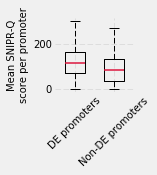

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([de, nonde], sym='', widths=[0.5, 0.5], whiskerprops=whiskerprops,
           boxprops=boxprops, medianprops=medianprops)
    
ax.set_ylabel('Mean SNIPR-Q\nscore per promoter', fontsize=10)
ax.set_xticklabels(['DE promoters', 'Non-DE promoters'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MEDIAN.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MEDIAN.svg', transparent=True, edgecolor='none')

plt.show()

In [9]:
a = np.array([np.max(x) for x in de_snipr])
b = np.array([np.max(x) for x in nonde_snipr])
pvals = []
for i in tqdm(range(10000)):
    x = [a[np.random.randint(len(a))] for x in range(100)]
    y = [b[np.random.randint(len(b))] for x in range(100)]
    pvals.append(mannwhitneyu(x, y)[1])
np.median(pvals), np.mean(a)/np.mean(b)

100%|██████████| 10000/10000 [00:15<00:00, 665.13it/s]


(0.0054266384209517033, 1.1283666764319003)

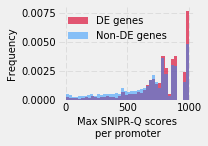

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.3))

ax.hist(a, alpha=0.7, bins=40, color='crimson', label='DE genes', normed=True)
ax.hist(b, alpha=0.5, bins=40, color='dodgerblue', label='Non-DE genes', normed=True)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Max SNIPR-Q scores\nper promoter', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MAX.svg',
            transparent=True, edgecolor='none')
plt.show()

In [11]:
a = de_snipr.mean(axis=0)
b = nonde_snipr.mean(axis=0)
np.median(mannwhitneyu(a, b)[1]), np.mean(a),  np.mean(b), np.mean(a)/np.mean(b), 

(3.6128695737783532e-126,
 119.5377776816609,
 89.703479436418675,
 1.332587971310395)

In [12]:
non_de_reshaped = nonde_snipr.reshape(1000, 2312, 1000)
per_pos_mean = non_de_reshaped.mean(axis=1)
random_min_max = np.array([per_pos_mean.min(axis=0), per_pos_mean.max(axis=0)])

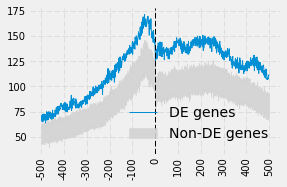

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))

ax.plot(de_snipr.mean(axis=0), lw=1, label='DE genes')
ax.fill_between(range(1000), random_min_max[0], random_min_max[1],
                color='lightgrey', alpha=0.9, label='Non-DE genes')
ax.axvline(500, lw=1, ls='--', c='k')
ax.set_xticks(range(0, 1100, 100))
ax.set_xticklabels(range(-500, 600, 100), rotation=90)
clean_axis(ax)
ax.legend(loc='best', frameon=False)
plt.savefig('../images/phendc3_rna_seq_snipr_position_wise_wrt_TSS.svg',
            transparent=True, edgecolor='none')
plt.show()

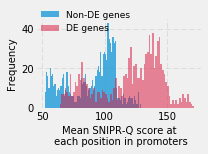

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.2))

ax.hist(b, bins=80, alpha=0.7, label='Non-DE genes')
ax.hist(a, bins=80, alpha=0.5, color='crimson', label='DE genes')
ax.set_xlabel('Mean SNIPR-Q score at\n each position in promoters', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.legend(frameon=False, loc= (0, 0.8), fontsize=9)
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_position_wise.svg',
            transparent=True, edgecolor='none')

plt.show()

In [12]:
offset = 500
sequences = []
hunter_genes = []
for chrom in chroms:
    print (chrom)
    chrom_seq = ''.join([x.rstrip('\n').upper() for x in open(
        '/home/parashar/scratch/hg19_resource/chromosomes/%s.fa' % chrom).readlines()[1:]])
    for gene, info in chrom_wise_gene_locus_map[chrom].items():
        hunter_genes.append(gene)
        if info[2] == '+':
            seq = chrom_seq[info[0] - offset : info[0] + offset]
        else:
            seq = chrom_seq[info[1] - offset : info[1] + offset][::-1]
        sequences.append(seq)
    clear_output()
with open('../data/ligands_rna_seq/promoter_sequences.seq', 'w') as OUT:
    OUT.write("\n".join(sequences))

In [13]:
hunter_script = '/home/parashar/scratch/quadcomb/scripts/G4Hunter.r'
in_fn = '../data/ligands_rna_seq/promoter_sequences.seq'
out_fn = '../data/ligands_rna_seq/hunter_scores.txt'
! Rscript $hunter_script $in_fn $out_fn
clear_output()

In [14]:
hunter_scores = []
with open('../data/ligands_rna_seq/hunter_scores.txt') as h:
    next(h)
    for l in h:
        c = l.rstrip('\n').split('\t')
        hunter_scores.append(abs(float(c[1])))
len(hunter_scores)

21050

In [15]:
de_hunter = []
rest_hunter = []
for gene,s in zip(hunter_genes, hunter_scores):
    if gene in phendc3_up_genes or gene in phendc3_down_genes:
        de_hunter.append(s)
    else:
        rest_hunter.append(s)
de_hunter = np.array(de_hunter)
rest_hunter = np.array(rest_hunter)

In [39]:
pvals = []
nonde = []
for i in tqdm(range(10000)):
    b = np.array([rest_hunter[np.random.randint(len(rest_hunter))]
                  for x in range(len(de_hunter))])
    nonde.extend(b)
    x = [de_hunter[np.random.randint(len(de_hunter))] for x in range(100)]
    y = [b[np.random.randint(len(b))] for x in range(100)]
    pvals.append(mannwhitneyu(x, y)[1])
np.median(pvals)

100%|██████████| 1000/1000 [00:12<00:00, 79.88it/s]


0.064506657556406305

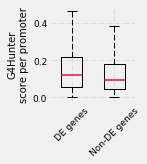

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([de_hunter, nonde], sym='', widths=[0.5, 0.5],
          boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

ax.set_ylabel('G4Hunter\nscore per promoter', fontsize=10)
ax.set_xticklabels(['DE genes', 'Non-DE genes'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_hunter_promoter_wise.svg',
            transparent=True, edgecolor='none')
plt.show()

In [76]:
hunter_fc = []
for i in tqdm(range(1000)):
    b = np.array([b[np.random.randint(len(b))] for x in range(len(a))])
    hunter_fc.append(np.mean(a)/np.mean(b))
hunter_fc = sorted(hunter_fc)

100%|██████████| 1000/1000 [00:11<00:00, 86.88it/s]


In [81]:
hunter_fc[50], hunter_fc[950]

(1.1089837575722898, 1.3291701312394457)